# Cliff Walking Q-Learning vs Sarsa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## Cliff GridWorld 환경 

GridWorld라는 클래스를 정의하여 GridWorld 환경을 구현합니다. 

플레이어의 행동에 따라 상태를 업데이트합니다.

UP, DOWN, RIGHT, LEFT 행동에 따라 플레이어의 위치를 변경합니다.
플레이어가 절벽에 도달하면 -100의 보상을 받고 에피소드가 종료됩니다.
플레이어가 목표에 도달하면 0의 보상을 받고 에피소드가 종료됩니다.
그 외의 경우에는 -1의 보상을 받고 에피소드는 계속됩니다.

In [3]:
class GridWorld:
    # 지형의 색상을 정의한 딕셔너리
    terrain_color = dict(normal=[128, 128, 128],  # 일반 지형: 회색
                         objective=[255, 0, 0],   # 목표 지형: 빨간색
                         cliff=[0, 0, 255],       # 절벽 지형: 파란색
                         player=[255, 255, 0])    # 플레이어: 노란색
        
    def __init__(self):
        # 그리드를 초기화하여 모든 셀을 일반 지형으로 설정
        self.grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
        # 플레이어의 초기 위치를 설정
        self.grid[-1, 0] = self.terrain_color['player']
        # 절벽 위치를 설정
        self.grid[-1, 1:11] = self.terrain_color['cliff']
        # 목표 위치를 설정
        self.grid[-1, -1] = self.terrain_color['objective']
    
        # 그리드를 그리는 함수 호출
        self._draw_grid()
            
    def _draw_grid(self):
        # 그리드를 시각화하기 위한 설정
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.ax.grid(which='minor') 
        for idx in range(12 * 4):
            # 그리드 셀마다 텍스트 추가 (인덱스 및 위치)
            self.ax.text(*self._id_to_position(idx)[::-1], 
                         str(idx) + '/' + str(self._id_to_position(idx)),
                         horizontalalignment="center") 
         
        # 그리드를 이미지로 표시
        self.ax.imshow(self.grid.astype(np.uint8), cmap='terrain')        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)

    def show_grid(self, Q):
        # Q 값과 함께 그리드를 시각화하기 위한 설정
        self.fig, self.ax = plt.subplots(figsize=(16, 8))
        self.ax.grid(which='minor') 
        for idx in range(12 * 4):
            # 그리드 셀마다 Q 값 추가
            self.ax.text(*self._id_to_position(idx)[::-1],                    
                "\n".join("{:.2f}".format(k) for k in Q[idx]),
                        horizontalalignment="center", 
                        verticalalignment="center", fontsize=12) 
         
        # 그리드를 이미지로 표시
        self.ax.imshow(self.grid.astype(np.uint8), cmap='terrain')        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)
        self.ax.set_title("up, down, right, left")
    
    def _id_to_position(self, idx):
        # 인덱스를 (y, x) 좌표로 변환
        return (idx // 12), (idx % 12)  # (y, x)
    
    def reset(self):
        # 플레이어를 초기 위치로 재설정
        self.player = (3, 0)        
        return self._position_to_id(self.player)
    
    def _position_to_id(self, pos):
        ''' x, y 좌표를 고유 ID로 매핑 --> y * 12 + x 
            pos : (y, x) 
        '''
        return pos[0] * 12 + pos[1]  

    def step(self, action):
        # 행동에 따른 플레이어의 이동 (UP = 0, DOWN = 1, RIGHT = 2, LEFT = 3)
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < 3:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < 11:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
            
        # 규칙 적용
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            # 플레이어가 절벽에 도달하면 -100 보상과 함께 에피소드 종료
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            # 플레이어가 목표에 도달하면 0 보상과 함께 에피소드 종료
            reward = 0
            done = True
        else:
            # 그 외의 경우에는 -1 보상과 함께 에피소드 계속
            reward = -1
            done = False
        # 플레이어의 새로운 위치의 인덱스, 보상, 에피소드 종료 여부를 반환합니다.
        return self._position_to_id(self.player), reward, done

### environment 생성
- <상태 인덱스> / (<행 인덱스>, <열 인덱스>)

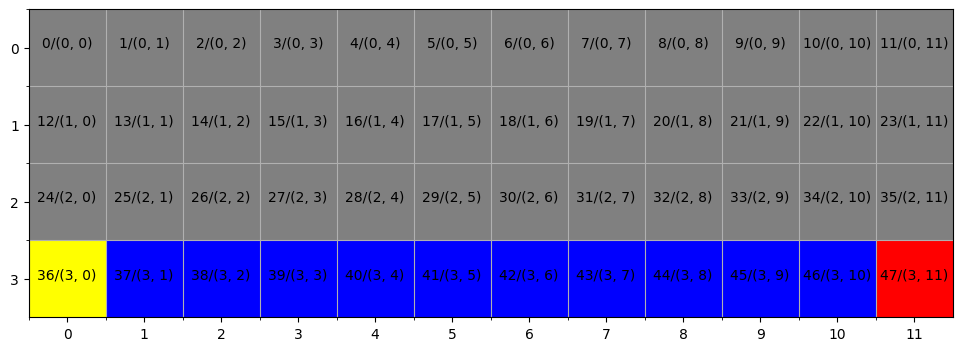

In [4]:
env = GridWorld()
env

- action space 정의

In [5]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']

- state 수, action 수 계산

In [6]:
num_states = 4 * 12
num_actions = 4

- 정책 정의

In [7]:
# epsilon-greedy policy
def pi(Q, state, e=0.1):
    if np.random.random() < e:
        return np.random.choice(4)
    else:
        return np.argmax(Q[state])

### Q-Learning, Sarsa 알고리즘 정의

- Q-Learning에서는 `np.max(Q[s_])`를 사용하여 다음 상태에서 가능한 행동 중 최대 Q 값을 선택합니다.
- Sarsa에서는 `pi(Q, s_, epsilon)`를 사용하여 다음 상태에서 실제로 선택된 행동 a_의 Q 값을 선택합니다.

In [8]:
# 에피소드 수, 할인 인자, 학습률, 탐색률 설정
num_episodes = 500
gamma = 0.9
alpha = 0.5
epsilon = 0.1

# Q-Learning 알고리즘 구현
def Q_Learning():
    Q = defaultdict(lambda: np.zeros(num_actions))  # Q 테이블 초기화
    
    for episode in range(num_episodes):   
        s = env.reset()  # 환경 초기화 및 초기 상태 설정
        done = False  
        while not done:
            # 행동 선택
            a = pi(Q, s, epsilon)
            s_, r, done = env.step(a)  # 행동 수행 및 보상과 다음 상태 관찰
            # Q 값 업데이트
            Q[s][a] += alpha * (r + gamma * np.max(Q[s_]) - Q[s][a])
            s = s_  # 상태 업데이트
            
    return Q

# Sarsa 알고리즘 구현
def Sarsa():
    Q = defaultdict(lambda: np.zeros(num_actions))  # Q 테이블 초기화
    
    for episode in range(num_episodes):   
        s = env.reset()  # 환경 초기화 및 초기 상태 설정
        done = False  
        # 행동 선택
        a = pi(Q, s, epsilon)
        while not done:
            s_, r, done = env.step(a)  # 행동 수행 및 보상과 다음 상태 관찰
            # 다음 행동 선택
            a_ = pi(Q, s_, epsilon)      
            # Q 값 업데이트
            Q[s][a] += alpha * (r + gamma * Q[s_][a_] - Q[s][a])
            s = s_  # 상태 업데이트
            a = a_  # 행동 업데이트
            
    return Q

### Q-Learning state-action value table 시각화

- 각 셀은 하나의 상태(state)에 해당. 셀 내부에는 4개의 Q값이 세로로 나열되어 있음

```
위쪽: Q(s, up)
두 번째: Q(s, down)
세 번째: Q(s, right)
네 번째: Q(s, left)
```

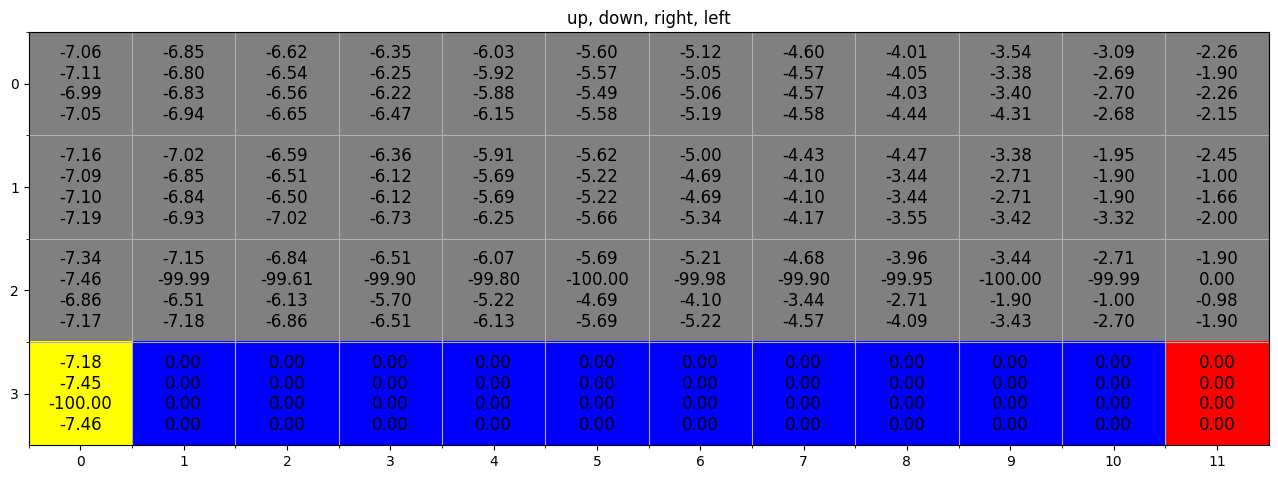

In [10]:
Q = Q_Learning()

env.show_grid(Q)

- Sarsa state-action value table 시각화

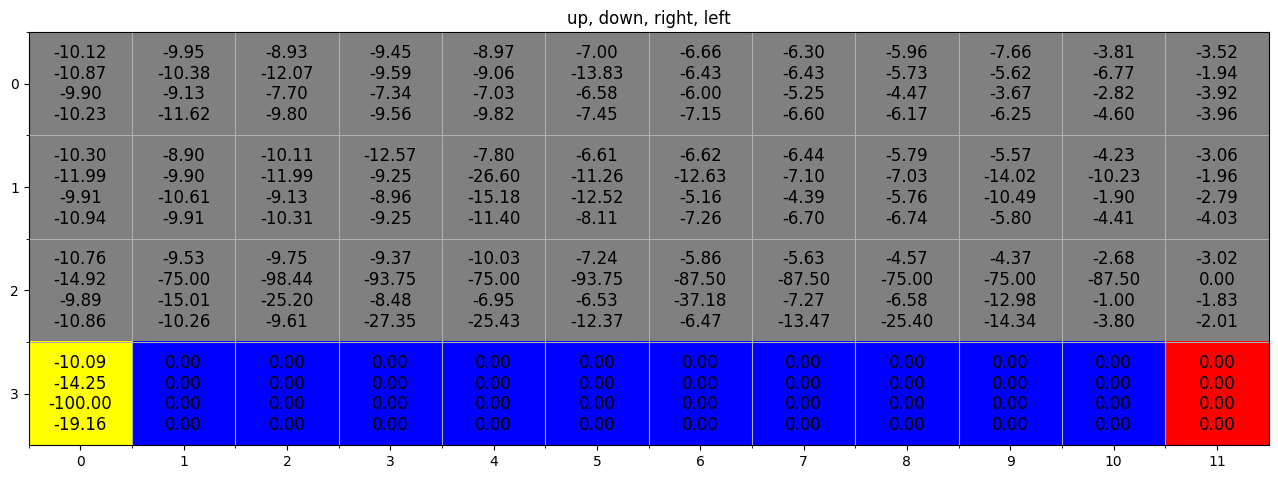

In [11]:
Q = Sarsa()

env.show_grid(Q)